# Generate coefficient plot per plate to visualize the feature importances

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


In [2]:
# Set the output directory for figures
output_dir <- "figures/coefficient_plots"

# Create the directory if it doesn't exist
if (!dir.exists(output_dir)) {
    dir.create(output_dir, recursive = TRUE)
}

cat("Output directory set to:", output_dir, "\n")

Output directory set to: figures/coefficient_plots 


In [3]:
# instantiate a list to hold the coefficients
coefficients_dict <- list()

# load all CSV files paths from the "coefficients" folder
coefficients_folder <- "coefficients"
csv_files <- list.files(coefficients_folder, pattern = "\\.csv$", full.names = TRUE)

# read in coefficients per model
for (file in csv_files) {
    df <- read.csv(file)
    
    if (!"Model" %in% names(df)) {
        warning(paste("Skipping", file, "- no 'Model' column found."))
        next
    }
    
    model_name <- unique(df$Model)
    
    if (length(model_name) != 1) {
        warning(paste("Skipping", file, "- multiple or no unique model names:", paste(model_name, collapse = ", ")))
        next
    }
    
    coefficients_dict[[model_name]] <- df
}

# print the names of the models
cat(names(coefficients_dict), sep = "\n")

combined_batch1
localhost240926150001
localhost240927060001
localhost240927120001
localhost240928120001


In [4]:
# Process each model's coefficients
processed_dict <- lapply(coefficients_dict, function(df) {
    df %>%
        arrange(desc(abs(Coefficient))) %>%
        tidyr::separate(
            Feature,
            into = c(
                "compartment", "feature_group", "measurement",
                "channel", "parameter1", "parameter2", "parameter3"
            ),
            sep = "_",
            remove = FALSE,
            fill = "right"
        ) %>%
        mutate(
            Coefficient = abs(Coefficient),
            channel_cleaned = case_when(
                channel == "Hoechst" ~ "Nucleus",
                channel == "ER" ~ "ER",
                channel == "Actin" ~ "Actin",
                channel == "Mitochondria" ~ "Mito",
                channel == "PM" ~ "PM",
                TRUE ~ "other"
            )
        ) %>%
        filter(channel_cleaned %in% c("Mito", "Nucleus", "PM", "ER", "Actin", "other")) %>%
        group_by(feature_group, channel_cleaned, compartment) %>%
        slice_max(order_by = Coefficient, n = 1) %>%
        ungroup()
})

# Print one example cleaned output — the first model in the dict
example_name <- names(processed_dict)[1]
cat("Model:", example_name, "\n")
head(processed_dict[[example_name]], 5)


Model: combined_batch1 


Feature,compartment,feature_group,measurement,channel,parameter1,parameter2,parameter3,Coefficient,Model,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
Cells_AreaShape_Perimeter,Cells,AreaShape,Perimeter,NA,NA,NA,NA,0.3715884,combined_batch1,other
Cytoplasm_AreaShape_Area,Cytoplasm,AreaShape,Area,NA,NA,NA,NA,0.3329575,combined_batch1,other
Nuclei_AreaShape_MinFeretDiameter,Nuclei,AreaShape,MinFeretDiameter,NA,NA,NA,NA,0.1795248,combined_batch1,other
Cells_Correlation_Correlation_Actin_Mitochondria,Cells,Correlation,Correlation,Actin,Mitochondria,NA,NA,0.2059167,combined_batch1,Actin
Cytoplasm_Correlation_RWC_Actin_PM,Cytoplasm,Correlation,RWC,Actin,PM,NA,NA,0.1193071,combined_batch1,Actin


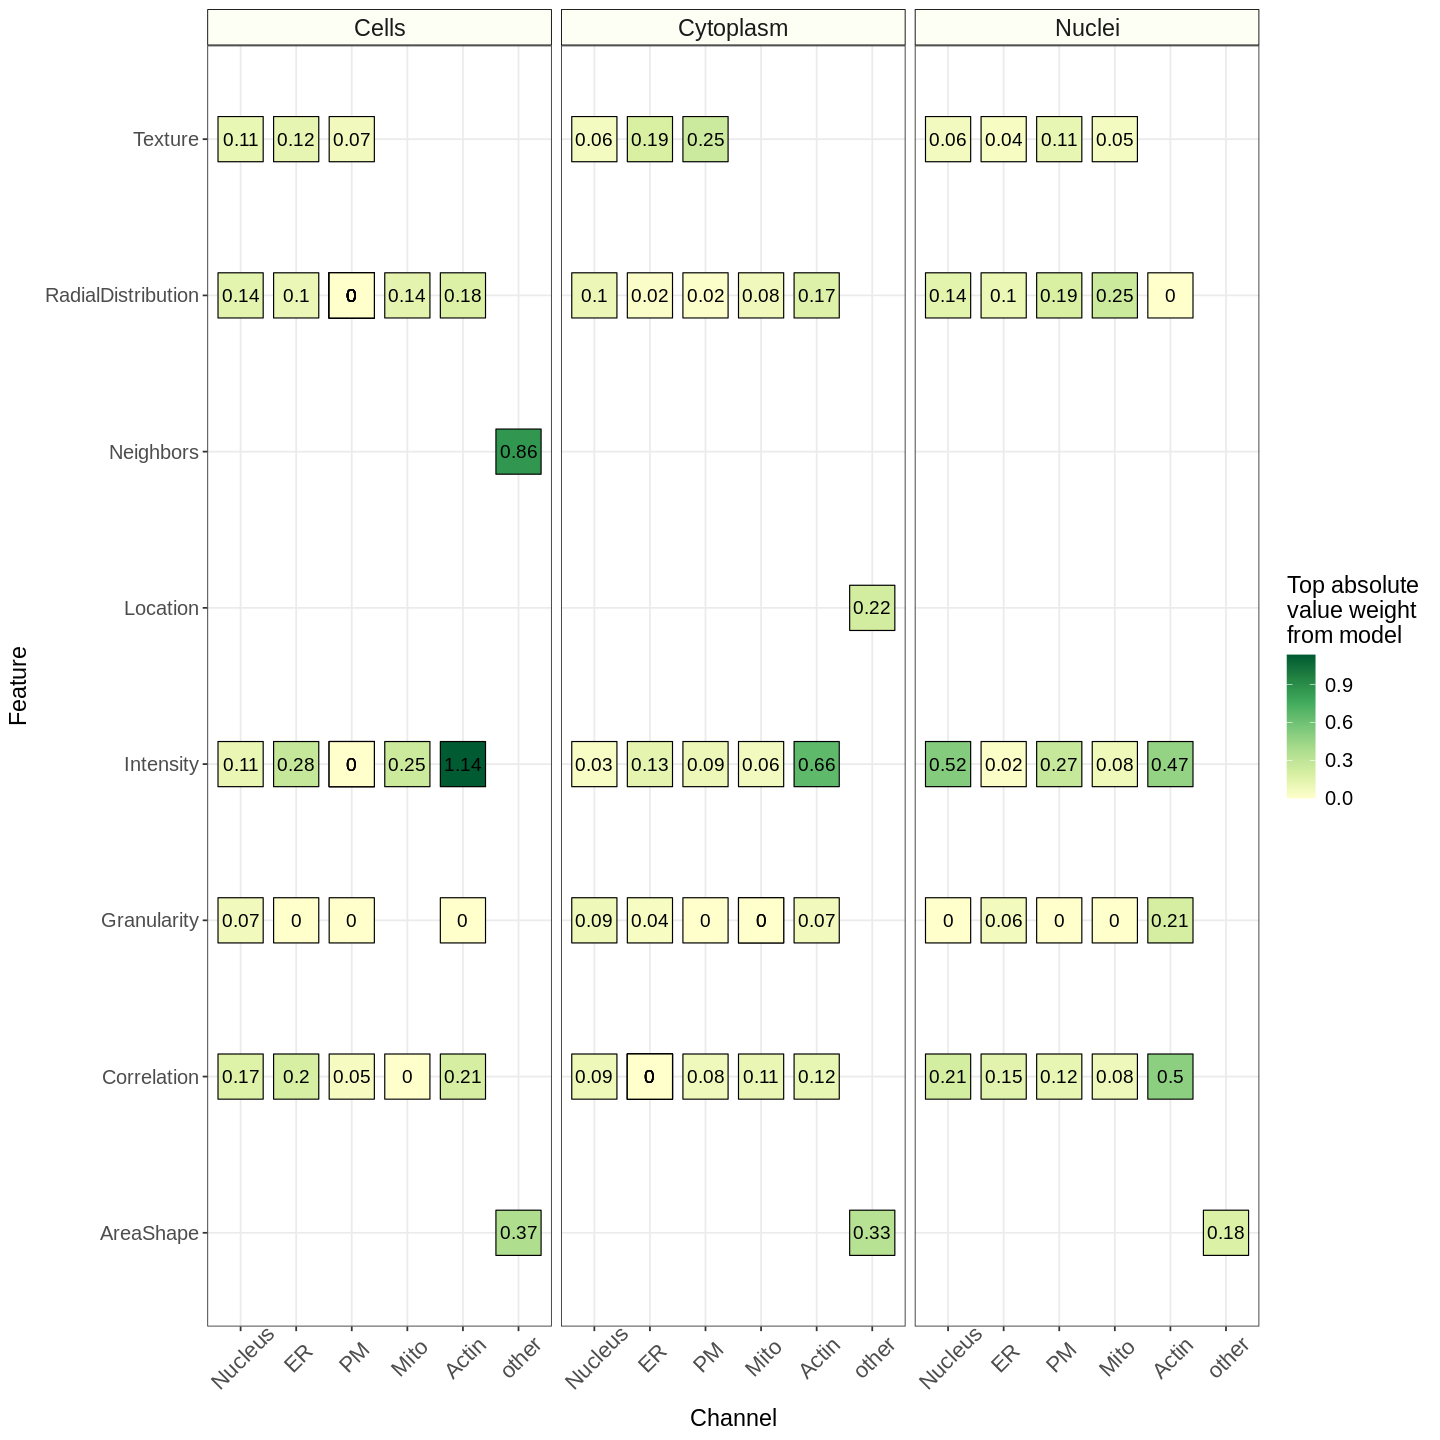

In [5]:
# Set channel order
channel_order <- c("Nucleus", "ER", "PM", "Mito", "Actin", "other")

# Set height and width of plot for visualizing
width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)

# Loop through each model in the dictionary and make a plot
plots <- lapply(names(processed_dict), function(model_name) {
    df <- processed_dict[[model_name]] %>%
        mutate(
            rounded_coeff = round(Coefficient, 2),
            channel_cleaned = factor(channel_cleaned, levels = channel_order)
        )
    
    gg <- ggplot(df, aes(x = channel_cleaned, y = feature_group)) +
        geom_point(aes(fill = Coefficient), pch = 22, size = 14) +
        geom_text(aes(label = rounded_coeff), size = 4) +
        facet_wrap("~compartment", ncol = 3) +
        theme_bw() +
        scale_fill_distiller(
            name = "Top absolute\nvalue weight\nfrom model",
            palette = "YlGn",
            direction = 1
        ) +
        xlab("Channel") +
        ylab("Feature") +
        theme(
            axis.text = element_text(size = 12),
            axis.text.x = element_text(angle = 45, size = 13, vjust = 0.7, hjust = 0.5),
            axis.title = element_text(size = 14),
            legend.text = element_text(size = 12),
            legend.title = element_text(size = 14),
            strip.text = element_text(size = 14),
            strip.background = element_rect(colour = "black", fill = "#fdfff4"),
            legend.position = "right"
        )
    
    # Save coefficient plots
    ggsave(filename = paste0(output_dir, "/", model_name, "_coef_plot.png"), plot = gg, height = 5, width = 11.5, dpi = 500)

    return(gg)
})

# Print first plot as an example
plots[[1]]
